# Initial Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# !uv pip install langchain_google_genai langchain langchain_community langchain-groq langchain_openai langgraph grandalf

In [3]:
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain.agents import initialize_agent, tool
from langchain_community.tools import TavilySearchResults
import datetime, os, getpass

In [4]:
load_dotenv(override=True)

True

In [5]:
#Check for environment variables
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [6]:
#Make sure this exists
_set_env("OPENAI_API_KEY")

In [272]:
# #Set the following env variables
# LANGSMITH_TRACING="true"
# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# LANGSMITH_API_KEY="<your-api-key>"
# LANGSMITH_PROJECT="your-project-name"

In [32]:
#Checks
_set_env("LANGSMITH_TRACING")
_set_env("LANGSMITH_ENDPOINT")
_set_env("LANGSMITH_API_KEY")
_set_env("LANGCHAIN_PROJECT")

**All invocations of LangChain runnables within your applications are automatically traced, by setting the above environment variables. For other scenarios, there are other ways to do this.**

# Basic ReACT Agent

In [7]:
model_name = "gpt-4o-mini"
llm = ChatOpenAI(
    model = model_name
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
)

In [8]:
search_tool = TavilySearchResults(search_depth="basic")

/var/folders/lf/hqk7z7j55856d37927df0b2w0000gn/T/ipykernel_7826/3131362913.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(search_depth="basic")


In [9]:
@tool
def get_system_time(format: str = "%Y-%m-%d %H:%M:%S"):
    """ Returns the current date and time in the specified format """

    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime(format)
    return formatted_time

In [10]:
tools = [search_tool, get_system_time]

In [12]:
#LangChain's in-built class using initialize_agent and AgentExecutor
agent = initialize_agent(tools=tools, llm=llm, agent="zero-shot-react-description", verbose=True)

In [13]:
agent.invoke("What is TrueFoundry?")



> Entering new AgentExecutor chain...
I need to gather information about TrueFoundry to understand what it is and what services or products it offers. I'll start by searching for it online to get the most accurate and up-to-date information.  
Action: tavily_search_results_json  
Action Input: "What is TrueFoundry?"  
Observation: [{'title': 'TrueFoundry: Enterprise‑Ready Agentic AI', 'url': 'https://www.truefoundry.com/', 'content': 'Enterprise‑Ready Agentic AI | TrueFoundry How Nvidia uses LLM Agents to Optimize GPU Cluster Utilization # Enterprise‑Ready Agentic AI — Secure, Scalable, Governed ## Govern, Deploy, Scale & Trace Agentic AI in One Unified Platform ## Orchestrate Agentic AI with AI Gateway Enable intelligent multi-step reasoning, tool usage, and memory with full control and visibility across your AI agents and workflows. ## Deploy and Scale Any Agentic AI Workload ### Host any AI Model Provision dedicated Model Control Protocol (MCP) servers to manage agent traffic, sca

{'input': 'What is TrueFoundry?',
 'output': 'TrueFoundry is a cloud-native Platform as a Service (PaaS) designed for ML teams to build, deploy, and manage ML and LLM applications efficiently, providing features that streamline the development and governance of AI workloads.'}

# Basic Reflection Agent

In [120]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import StateGraph, END, MessagesState

**Also, cover how the MessagesState uses the add_messages reducer function under the hood.**

In [150]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a twitter techie influencer assistant tasked with writing excellent twitter posts."
            " Generate the best twitter post possible for the user's request."
            " If the user provides critique, respond with a revised version of your previous attempts.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [151]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a viral twitter influencer grading a tweet. Your task is to critique the user's tweet."
            " Provide a few recommendations in less than a line for improvement. If the tweet is excellent and no more revisions are needed, end your critique with the word 'STOP'."
            " If more revisions are needed, end your critique with the word 'REVISE'.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [152]:
generation_chain = generation_prompt | llm
reflection_chain = reflection_prompt | llm

In [153]:
REFLECT = "reflect"
GENERATE = "generate"

In [154]:
#Define generate node
def generate_node(state: MessagesState):
    response = generation_chain.invoke({
        "messages": state['messages']
    })
    return {"messages": [response]} # Return a dictionary with the new message to append to the state.

In [155]:
#Define reflect node
def reflect_node(state: MessagesState):
    last_ai_message = state["messages"][-1]
    response = reflection_chain.invoke({"messages": [last_ai_message]})
    
    return {"messages": [HumanMessage(content=response.content)]}

In [161]:
def should_continue(state: MessagesState):
    """
    Determines whether to continue the reflection loop based on the last critique.
    
    The reflection LLM is prompted to end its response with 'STOP' or 'REVISE'.
    We check for this signal.
    """
    last_message = state["messages"][-1]
    if "STOP" in last_message.content.upper():
        return "end"  # The critique says the tweet is good, so we end.
    elif (len(state["messages"]) > 6):
        return "end"
    else:
        return "generate"  # The critique says to revise, so we go back to the generate node.

In [162]:
# ## EXERCISE - SPOT THE ERRORS
# #Create graph
# graph = StateGraph(MessagesState)

# #Add nodes
# graph.add_node(GENERATE, generate_node)
# graph.add_node(REFLECT, reflect_node)

# #Set the entry point
# graph.set_entry_point(GENERATE)

# #Add edges
# graph.add_conditional_edges(GENERATE, should_continue)
# graph.add_edge(REFLECT, GENERATE)

# app = graph.compile()

# display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [163]:
#Create graph
graph = StateGraph(MessagesState)

#Add nodes
graph.add_node(GENERATE, generate_node)
graph.add_node(REFLECT, reflect_node)

#Set the entry point
graph.set_entry_point(GENERATE)

#Add edges
graph.add_edge(GENERATE, REFLECT)
graph.add_conditional_edges(REFLECT, 
                            should_continue,
                           {
                               "generate": GENERATE,
                               "end": END
                           })

app = graph.compile()

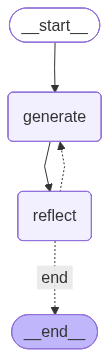

In [164]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [165]:
response = app.invoke({"messages":[HumanMessage(content="1 line on Indo-US relations")]})

print(response)

{'messages': [HumanMessage(content='1 line on Indo-US relations', additional_kwargs={}, response_metadata={}, id='3ec90343-14b2-447c-872c-f9b87c14e4f2'), AIMessage(content='"Strengthening ties, the Indo-US partnership is a powerful blend of innovation, diplomacy, and shared values driving global progress! 🇺🇸🤝🇮🇳 #IndoUSRelations"', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 41, 'prompt_tokens': 59, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CBx7c1JxJlXZ1BNtHMc4op66vZwSx', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--9ba4ba04-0a1d-4038-8667-dfc0bf0ae111-0', usage_metadata={'input_tokens': 59, 'output_tokens': 41, 'total_tokens': 1

# State Deep-Dive

## Simple Implementation

In [29]:
from typing import TypedDict, List, Annotated
from langgraph.graph import END, StateGraph
import operator

In [167]:
class SimpleState(TypedDict):
    count: int
    sum: Annotated[int, operator.add]
    history: Annotated[List[int], operator.concat]

In [168]:
def increment(state: SimpleState) -> SimpleState: 

    new_count = state["count"] + 1

    return {
        "count": new_count, 
        "sum": new_count, 
        "history": [new_count]
    }

In [169]:
def should_continue(state):
    if(state["count"] < 5): 
        return "continue"
    else: 
        return "stop"
    

In [170]:
#Initialize graph
graph = StateGraph(SimpleState)

#Add node
graph.add_node("increment", increment)

#Set entry point
graph.set_entry_point("increment")

# Add edges
graph.add_conditional_edges(
    "increment", 
    should_continue, 
    {
        "continue": "increment", 
        "stop": END
    }
)

#Compile
app = graph.compile()

In [171]:
state = {
    "count": 0, 
    "sum": 0, 
    "history": []
}

result = app.invoke(state)
print(result)

{'count': 5, 'sum': 15, 'history': [1, 2, 3, 4, 5]}


## Better Implementation

In [172]:
#Define a complex state with annotations
class ComplexState(TypedDict):
    count: int
    total_sum: Annotated[int, operator.add]
    history: Annotated[List[int], operator.concat]

In [173]:
#Define a node to update the state
def increment(state: ComplexState) -> ComplexState:
    new_count = state["count"] + 1
    
    # Return updates for each key. LangGraph handles the merging.
    return {
        "count": new_count,
        "total_sum": new_count, # LangGraph will add this to the total_sum
        "history": [new_count]  # LangGraph will concatenate this to the history list
    }

In [177]:
#Define a condition for the loop
def should_continue(state: ComplexState):
    if state["count"] < 5:
        return "continue"
    else:
        return "stop"
    

In [178]:
#Build and compile the graph
graph = StateGraph(ComplexState)
graph.add_node("increment", increment)
graph.set_entry_point("increment")
graph.add_conditional_edges(
    "increment",
    should_continue,
    {
        "continue": "increment",
        "stop": END
    }
)
app = graph.compile()

In [179]:
#Run the graph with an initial state
state = {
    "count": 0,
    "total_sum": 0,
    "history": []
}
result = app.invoke(state)
print(result)

{'count': 5, 'total_sum': 15, 'history': [1, 2, 3, 4, 5]}


# ReACT Agent using LangGraph - Part 1

In [34]:
from langchain.agents import tool, create_react_agent
from langgraph.graph import END, StateGraph
import datetime
from langchain_community.tools import TavilySearchResults
from langchain import hub

In [15]:
# Why do we want to use LangGraph instead of in-built LangChain function? - infinite loop problem and more control
# Combines two key components - create_react_agent and AgentExecutor class (this we will eliminate in LangGraph) 
# AgentExecutor controls the looping between LangChain and LLM

# What create_react_agent does -> Thought, action, action input and parses that into one of the 2 classes - AgentAction and AgentFinish
# What AgentExecutor does -> Takes agent from create_react_agent and manages execution loop; receives user's question and feeds to agent

## Reasoning Runnable

In [16]:
@tool
def get_system_time(format: str = "%Y-%m-%d %H:%M:%S"):
    """ Returns the current date and time in the specified format """

    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime(format)
    return formatted_time

In [17]:
search_tool = TavilySearchResults(search_depth="basic")

In [18]:
react_prompt = hub.pull("hwchase17/react")

In [19]:
print(react_prompt.template)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [20]:
tools = [get_system_time, search_tool]

In [21]:
react_agent_runnable = create_react_agent(tools=tools, llm=llm, prompt=react_prompt)

## State

In [22]:
import operator
from typing import Annotated, TypedDict, Union
from langchain_core.agents import AgentAction, AgentFinish

In [23]:
class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

## Building Nodes

In [24]:
def reason_node(state: AgentState):
    agent_outcome = react_agent_runnable.invoke(state)
    return {"agent_outcome": agent_outcome}

In [25]:
def act_node(state: AgentState):
    agent_action = state["agent_outcome"]
    
    ## ----- Since ToolExecutor is deprecated ----- START -----
    ## Else just do: output = tool_executor.invoke(agent_action)
    
    # Extract tool name and input from AgentAction
    tool_name = agent_action.tool
    tool_input = agent_action.tool_input
    
    # Find the matching tool function
    tool_function = None
    for tool in tools:
        if tool.name == tool_name:
            tool_function = tool
            break
    
    # Execute the tool with the input
    if tool_function:
        if isinstance(tool_input, dict):
            output = tool_function.invoke(**tool_input)
        else:
            output = tool_function.invoke(tool_input)
    else:
        output = f"Tool '{tool_name}' not found"
    
    ## ----- Since ToolExecutor is deprecated ----- END -----
    
    return {"intermediate_steps": [(agent_action, str(output))]}

## Final Graph

In [26]:
REASON_NODE = "reason_node"
ACT_NODE = "act_node"

In [27]:
def should_continue(state: AgentState) -> str:
    if isinstance(state["agent_outcome"], AgentFinish):
        return "end"
    else:
        return "act"

In [30]:
graph = StateGraph(AgentState)

graph.add_node(REASON_NODE, reason_node)
graph.add_node(ACT_NODE, act_node)

graph.set_entry_point(REASON_NODE)

graph.add_conditional_edges(
    REASON_NODE,
    should_continue,
    {
        "act": ACT_NODE,
        "end": END
    }
)

graph.add_edge(ACT_NODE, REASON_NODE)

app = graph.compile()

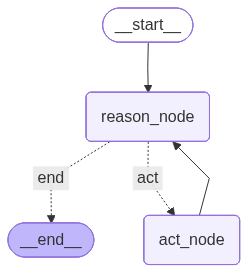

In [31]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [238]:
result = app.invoke(
    {
        "input": "How many years ago was the last Hackathon at TrueFoundry?", 
        "agent_outcome": None, 
        "intermediate_steps": []
    }
)

print(result["agent_outcome"].return_values["output"], "This is the final result.")

The last Hackathon at TrueFoundry was held approximately 2 years ago. This is the final result.


**Explore tracing the graph using LangSmith.**

In [275]:
# #Invoke and inspect for non LangChain
# from langsmith import traceable
# @traceable
# def get_response(question):
#     result = app.invoke(
#         {
#             "input": question, 
#             "agent_outcome": None, 
#             "intermediate_steps": []
#         }
#     )

#     return(result["agent_outcome"].return_values["output"], "This is the final result.")
# get_response("How many years ago was the last Hackathon at TrueFoundry?")

# ReACT Agent using LangGraph - Part 2

**This is recommended by LangChain to be the most production-ready way to do it.**

In [35]:
from langgraph.prebuilt import create_react_agent

In [36]:
#Initialize the agent
agent = create_react_agent(
    model=model_name,  
    tools=tools,  
    prompt="You are a helpful assistant"  
)

In [37]:
# Run the agent
agent.invoke(
    {"messages": [{"role": "user", "content": "How many years ago was the last Hackathon at TrueFoundry?"}]}
)

{'messages': [HumanMessage(content='How many years ago was the last Hackathon at TrueFoundry?', additional_kwargs={}, response_metadata={}, id='267b6b91-ca48-4332-bb3b-b276b85fe470'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GXA8eAtapgoJK33Qk7bfnzSh', 'function': {'arguments': '{"query":"last Hackathon at TrueFoundry"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 142, 'total_tokens': 166, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CBykUd3C8AVqfHXjkoLDTxqpmnggy', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--36f33e56-819b-4640-9b06-02292889c597-0', tool_

**Explore tracing the graph using LangSmith.**

## Add memory

In [38]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver

### Issue without memory

In [45]:
agent = create_react_agent(
    model=model_name,
    tools=tools)

In [46]:
first_response = agent.invoke(
    {"messages": [{"role": "user", "content": "What is TrueFoundry all about?"}]},
    config  
)

In [47]:
second_response = agent.invoke(
    {"messages": [{"role": "user", "content": "What's unique about it?"}]},
    config
)

In [48]:
second_response

{'messages': [HumanMessage(content="What's unique about it?", additional_kwargs={}, response_metadata={}, id='5cf4b510-c244-43e2-9ec0-150ae948532c'),
  AIMessage(content='Could you please provide more context or specify what you are referring to? It could be a product, a place, an event, or something else entirely.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 127, 'total_tokens': 159, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CByrchk4TDvOXDf0fNtQJhcWs1WFj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--372740fc-849b-4a86-b110-6759fef02c26-0', usage_metadata={'input_tokens': 127, 'output_tokens': 32, 'total_tokens': 159, 'input_t

### Resolved by memory

To enable multi-turn conversations with an agent, we need to 

1. **Enable persistence** by providing a **checkpointer** when creating an agent. Checkpoints save the complete state after a node finishes its work.

2. At runtime, we need to provide a config containing **thread_id** — which is simply a unique identifier for each specific conversation or workflow execution (session). This is important because there can be simultaneously running conversations/workflows.

In [39]:
checkpointer = InMemorySaver()

In [40]:
agent = create_react_agent(
    model=model_name,
    tools=tools,
    checkpointer=checkpointer  
)

In [41]:
# Run the agent
config = {"configurable": {"thread_id": "1"}}

In [42]:
first_response = agent.invoke(
    {"messages": [{"role": "user", "content": "What is TrueFoundry all about?"}]},
    config  
)

In [43]:
second_response = agent.invoke(
    {"messages": [{"role": "user", "content": "What's unique about it?"}]},
    config
)

In [44]:
second_response

{'messages': [HumanMessage(content='What is TrueFoundry all about?', additional_kwargs={}, response_metadata={}, id='330ca88d-f536-428e-961b-c8ff346b2944'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_X5T6vj6NG2jmjxroDqsuRgwO', 'function': {'arguments': '{"query":"TrueFoundry"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 130, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CBypp3gBk6AjvQVLfb97VanMB3jWC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--94fe0a40-2d81-4306-a55b-892b6255dac4-0', tool_calls=[{'name': 'tavily_search_results_json',

## Configure structured output

In [51]:
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent

In [52]:
class KeyEntities(BaseModel):
    entities: str = Field(description="Key named entities in the piece of text")

In [53]:
agent = create_react_agent(
    model=model_name,
    tools=tools,
    response_format=KeyEntities  
)

In [54]:
response = agent.invoke(
    {"messages": [{"role": "user", "content": "What's happening in Indo-US relations currently?"}]}
)

response["structured_response"]

KeyEntities(entities='India, United States, Biden, Modi, G20, Mission 500, Russian oil, trade relations')